In [43]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

import shapely
from shapely.geometry import Point
from scipy.ndimage import binary_dilation

import xarray as xr
import cartopy.crs as ccrs
import shapely.geometry as sg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [59]:
product = 'CMORPH'

In [60]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_simple.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [61]:
data_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [63]:
data_dir = os.path.join(data_base,product,'1dy',f'{product}_Italy_1dy_1998_01_01_2024_01_31.nc')

DATA = xr.open_dataset(data_dir)

lon2d, lat2d  = np.meshgrid(DATA.lon.values, DATA.lat.values)

reso = 0.25

<GeoAxes: >

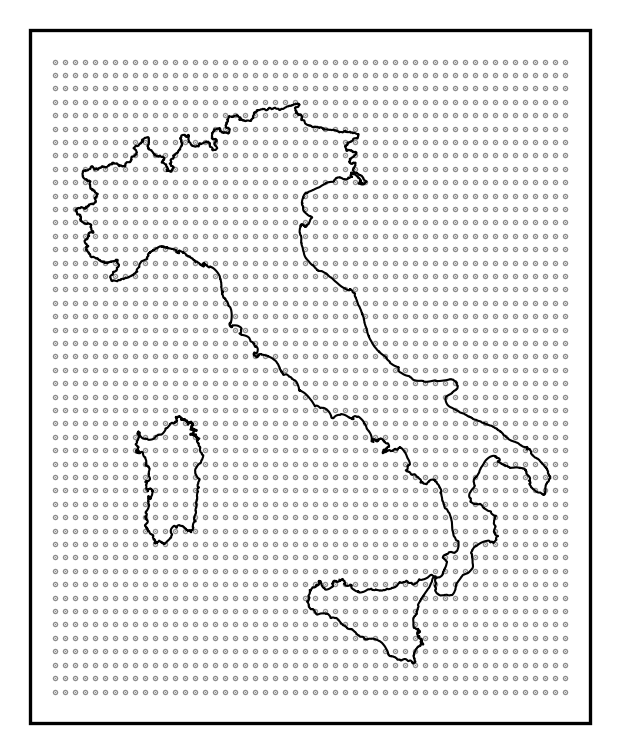

In [64]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.scatter(lon2d, lat2d, c='grey', s=0.1, alpha=0.9, zorder=10)
REGIONS.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)

In [74]:
expand1, expand2 = 1, 2

In [75]:
# Flatten para convertir a vectores
lon_flat = lon2d.ravel()
lat_flat = lat2d.ravel()

In [79]:
points = gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(lon_flat, lat_flat)], crs="EPSG:4326")
mask = points.within(REGIONS.union_all())

valid_lons = lon_flat[mask]
valid_lats = lat_flat[mask]

mask_2d = mask.values.reshape(lon2d.shape)

data_masked = DATA['PRE'].where(mask_2d) 

mask_expanded1 = binary_dilation(mask_2d, iterations=expand1)
data_masked1 = DATA['PRE'].where(mask_expanded1) 

mask_expanded2 = binary_dilation(mask_2d, iterations=expand2)
data_masked2 = DATA['PRE'].where(mask_expanded2) 

In [118]:
i_valid, j_valid = np.where(mask_expanded1)

# Asegúrate que lat2d y lon2d vienen del meshgrid de DATA.lat y DATA.lon
lon2d, lat2d = np.meshgrid(DATA.lon.values, DATA.lat.values)

# Extraer coordenadas reales de los puntos válidos
lat_valid = lat2d[i_valid, j_valid]
lon_valid = lon2d[i_valid, j_valid]

df_points = pd.DataFrame({
    'i': i_valid,
    'j': j_valid,
    'lat': lat_valid,
    'lon': lon_valid
})

df_points.head(4)

,i,j,lat,lon
0,2,34,36.625,14.625
1,2,35,36.625,14.875
2,2,36,36.625,15.125
3,3,31,36.875,13.875


/tmp/ipykernel_31442/4022786165.py:9: RuntimeWarning: Mean of empty slice
  a1 = ax1.contourf(lon2d, lat2d, np.nanmean(data_masked,axis=0), cmap=cmap)
/tmp/ipykernel_31442/4022786165.py:21: RuntimeWarning: Mean of empty slice
  a1 = ax1.contourf(lon2d, lat2d, np.nanmean(data_masked1,axis=0), cmap=cmap)
/tmp/ipykernel_31442/4022786165.py:32: RuntimeWarning: Mean of empty slice
  a1 = ax1.contourf(lon2d, lat2d, np.nanmean(data_masked2,axis=0), cmap=cmap)


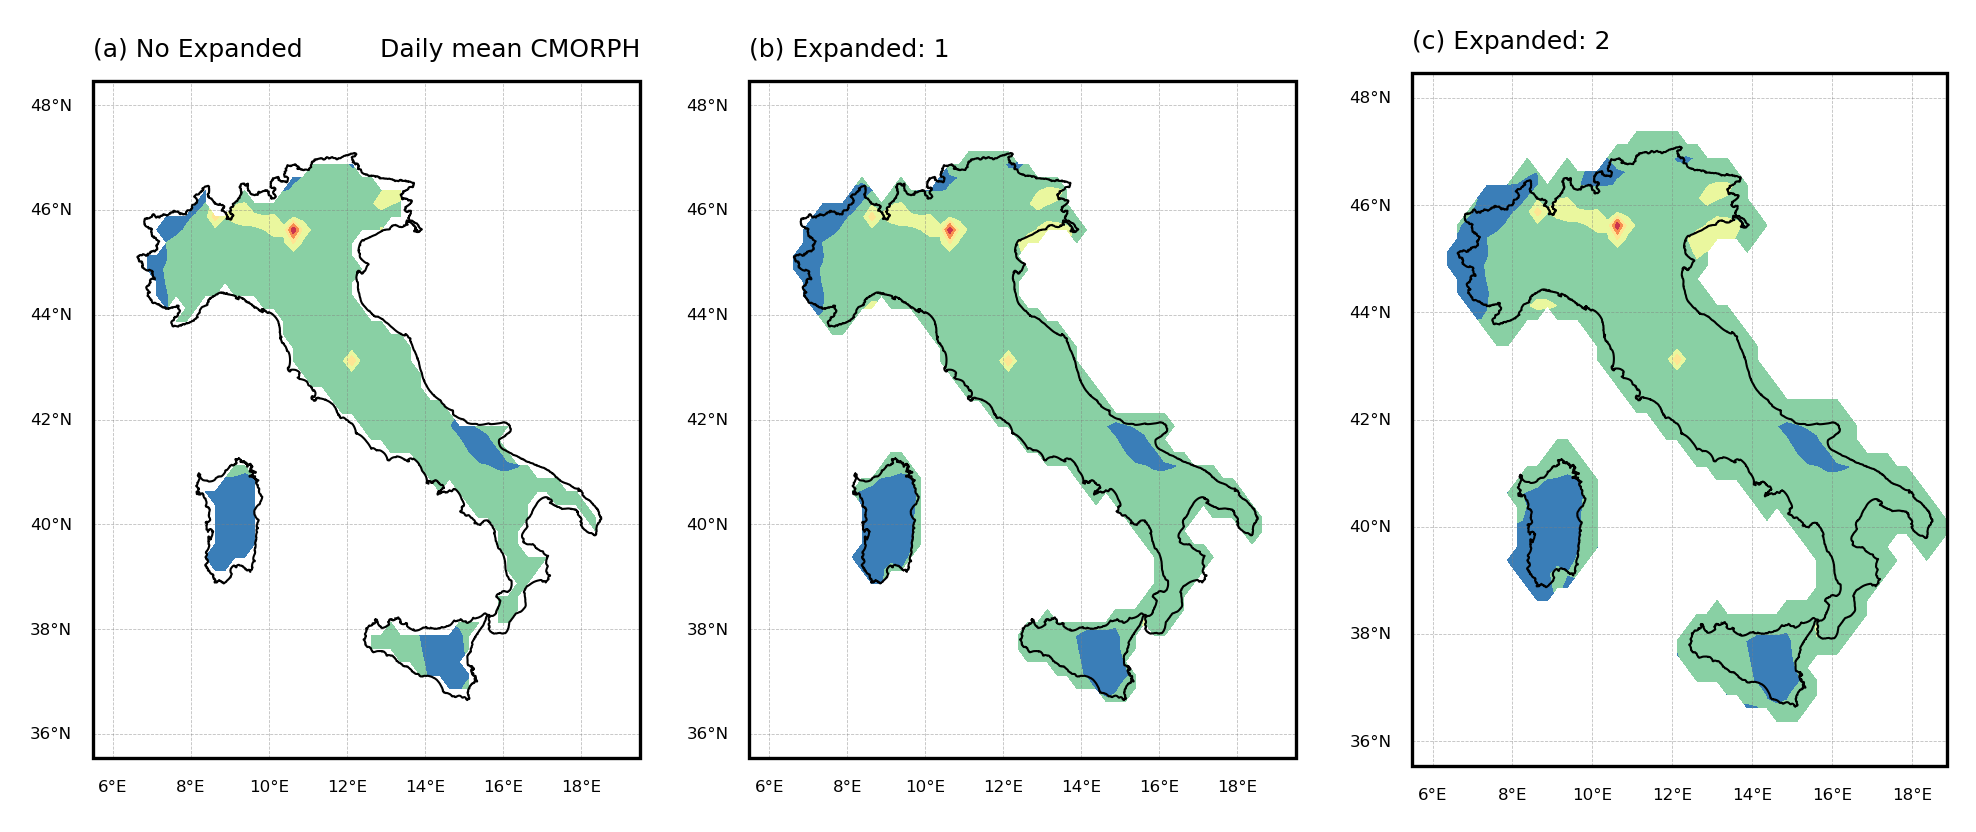

In [120]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,3)

ax1 = plt.subplot(gs[0, 0], projection = proj)
REGIONS.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(data_masked,axis=0), cmap=cmap)
ax1.set_title(f'(a) No Expanded', fontsize=6, loc='left')
ax1.set_title(f'Daily mean {product}', fontsize=6, loc='right')
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1 = plt.subplot(gs[0, 1], projection = proj)
REGIONS.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(data_masked1,axis=0), cmap=cmap)
ax1.set_title(f'(b) Expanded: {expand1}', fontsize=6, loc='left')
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1 = plt.subplot(gs[0, 2], projection = proj)
REGIONS.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(data_masked2,axis=0), cmap=cmap)
ax1.set_title(f'(c) Expanded: {expand2}', fontsize=6, loc='left')
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}
# ax1.scatter(df_points['lon'], df_points['lat'], c='r', s=0.1, alpha=0.9, zorder=10)